In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
df = pd.read_csv('../datasets/filtered_dataset.csv')
df

,Id,Overall Qual,Gr Liv Area,Garage Area,Garage Cars,Total Bsmt SF,1st Flr SF,Year Built,Year Remod/Add,Full Bath,...,Mo Sold_4,Mo Sold_5,Mo Sold_6,Mo Sold_7,Mo Sold_8,Mo Sold_9,Yr Sold_2007,Yr Sold_2008,Yr Sold_2009,Yr Sold_2010
0,109,6,1479,475.0,2.0,725.0,725,1976,2005,2,...,0,0,0,0,0,0,0,0,0,1
1,544,7,2122,559.0,2.0,913.0,913,1996,1997,2,...,1,0,0,0,0,0,0,0,1,0
2,153,5,1057,246.0,1.0,1057.0,1057,1953,2007,1,...,0,0,0,0,0,0,0,0,0,1
3,318,5,1444,400.0,2.0,384.0,744,2006,2007,2,...,1,0,0,0,0,0,0,0,0,1
4,255,6,1445,484.0,2.0,676.0,831,1900,1993,2,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022,1587,8,1728,520.0,2.0,1884.0,1728,2007,2007,2,...,0,0,0,0,0,0,0,1,0,0
2023,785,4,861,539.0,2.0,861.0,861,1940,1950,1,...,0,0,0,0,0,0,0,0,1,0
2024,916,6,1913,342.0,2.0,896.0,1172,1928,1950,1,...,0,0,0,0,0,0,0,0,1,0
2025,639,4,1200,294.0,1.0,1200.0,1200,1956,1956,1,...,0,0,0,0,0,0,0,0,1,0


In [4]:
df['OQGLA_mod'] = (df['Overall Qual'] * df['Gr Liv Area']) ** .75

In [5]:
top_corr_reduced = df.corr().abs().drop(['Id','SalePrice'])[['SalePrice']].sort_values('SalePrice', ascending=False)

In [6]:
top_corr_reduced[:15].index

Index(['OQGLA_mod', 'Overall Qual', 'Gr Liv Area', 'Garage Area',
       'Garage Cars', 'Total Bsmt SF', '1st Flr SF', 'Exter Qual_TA',
       'Year Built', 'Garage Yr Blt', 'Year Remod/Add', 'Kitchen Qual_TA',
       'Full Bath', 'Foundation_PConc', 'Mas Vnr Area'],
      dtype='object')

In [7]:
# Upper limit of features
np.sqrt(len(df) * .8)

40.26909484952449

In [8]:
top_corr_reduced[top_corr_reduced > .5].dropna()

,SalePrice
OQGLA_mod,0.843600
Overall Qual,0.799020
Gr Liv Area,0.698018
Garage Area,0.648760
Garage Cars,0.646917
Total Bsmt SF,0.629323
1st Flr SF,0.620635
Exter Qual_TA,0.599382
Year Built,0.571326
Garage Yr Blt,0.555339


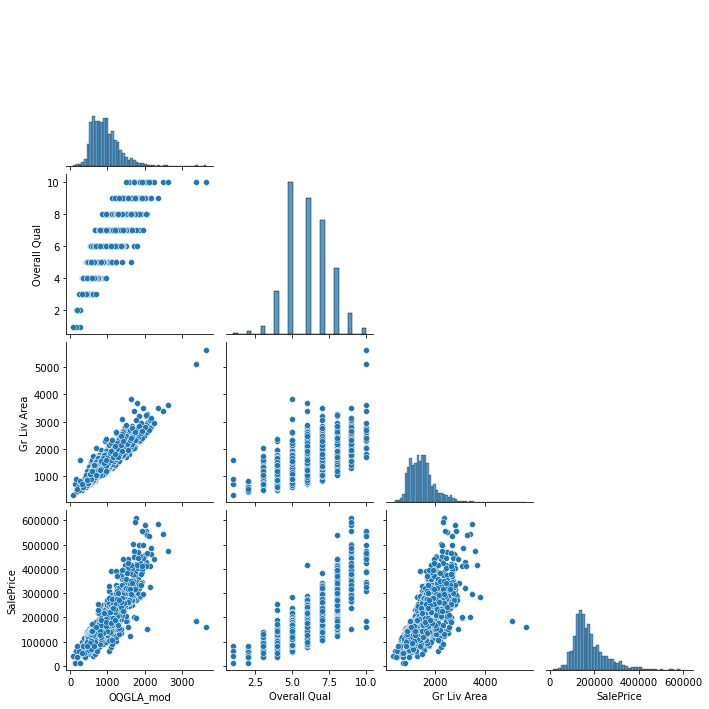

In [9]:
sns.pairplot(df[top_corr_reduced.index[:3]].join(df['SalePrice']), corner=True);

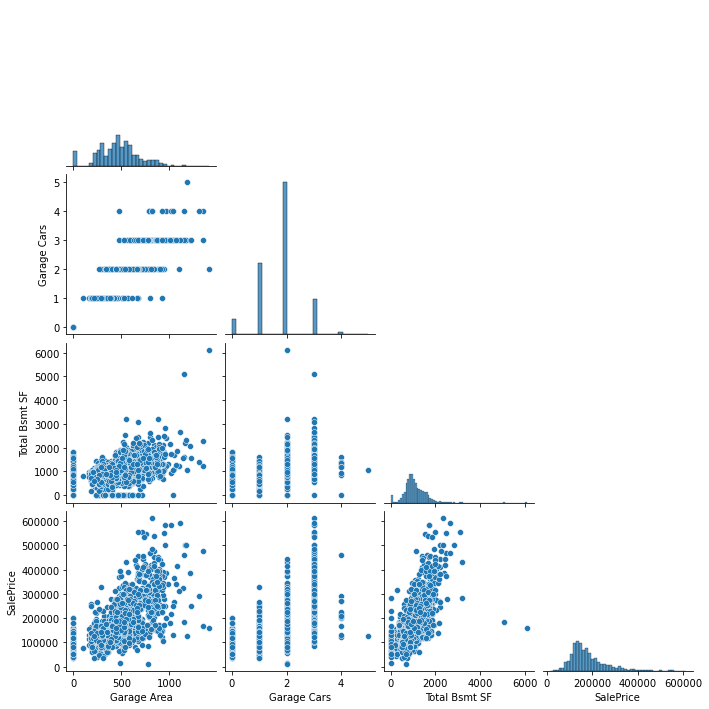

In [10]:
sns.pairplot(df[top_corr_reduced.index[3:6]].join(df['SalePrice']), corner=True);

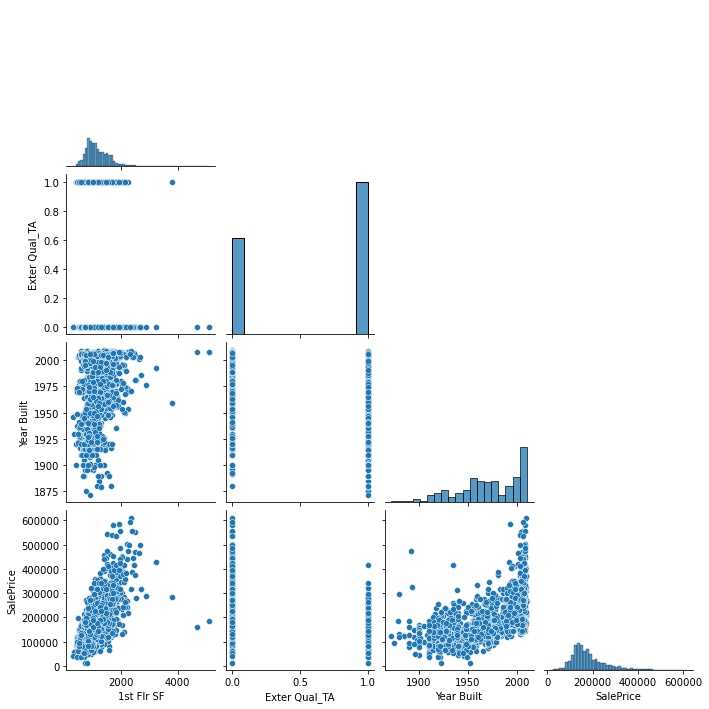

In [11]:
sns.pairplot(df[top_corr_reduced.index[6:9]].join(df['SalePrice']), corner=True);

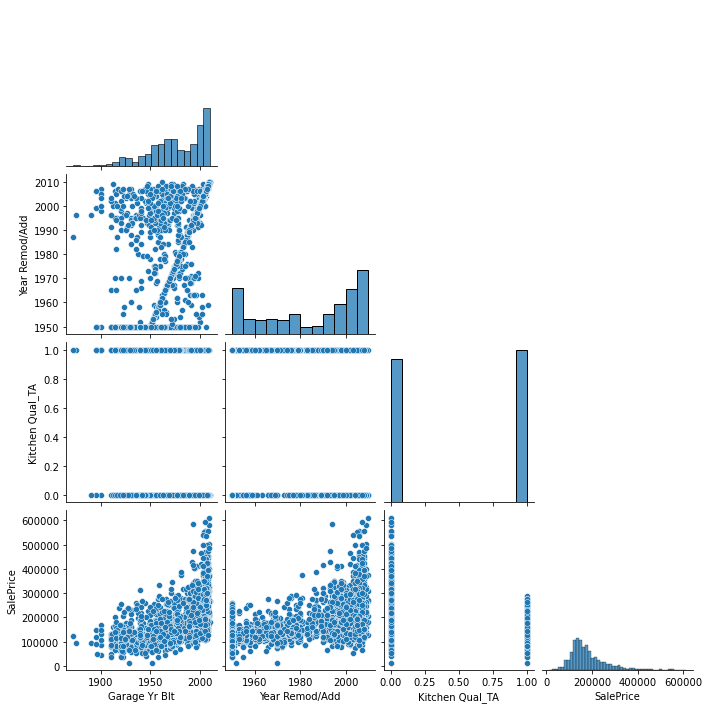

In [12]:
sns.pairplot(df[top_corr_reduced.index[9:12]].join(df['SalePrice']), corner=True);

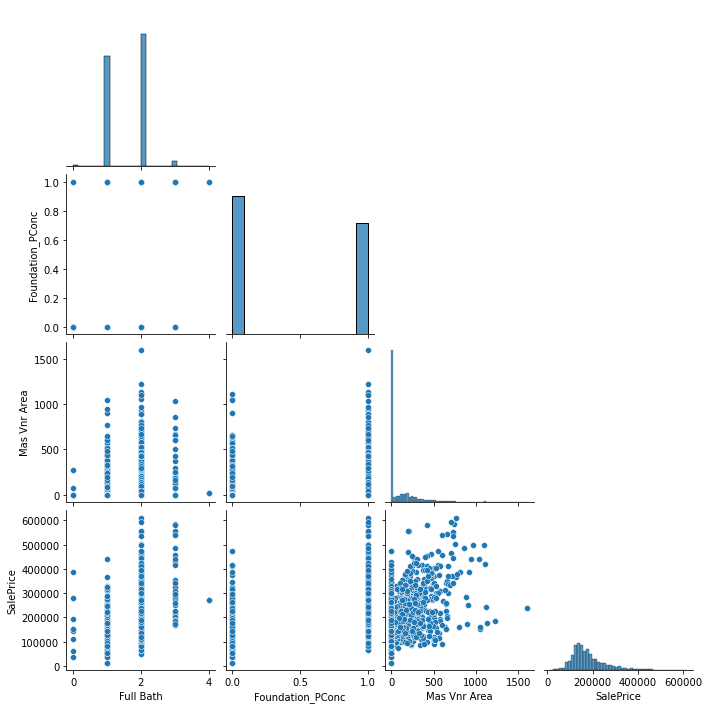

In [13]:
sns.pairplot(df[top_corr_reduced.index[12:15]].join(df['SalePrice']), corner=True);

<AxesSubplot:>

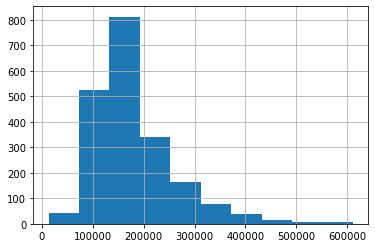

In [14]:
df['SalePrice'].hist()

<AxesSubplot:>

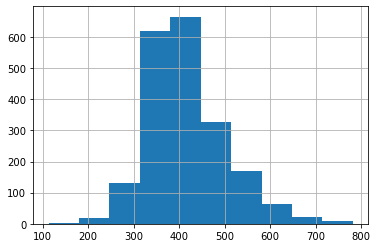

In [15]:
df['SalePrice'].map(np.sqrt).hist()

<AxesSubplot:>

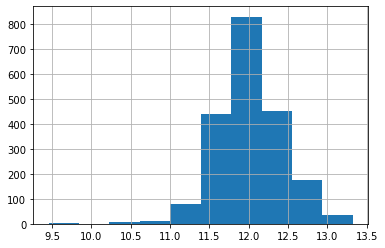

In [16]:
df['SalePrice'].map(np.log).hist()

In [17]:
df['log_SalePrice'] = df['SalePrice'].map(np.log)

In [18]:
df.corr().abs().drop(['Id','SalePrice','log_SalePrice'])[['log_SalePrice']].sort_values('log_SalePrice', ascending=False)

,log_SalePrice
OQGLA_mod,0.829044
Overall Qual,0.821529
Gr Liv Area,0.687978
Garage Cars,0.666286
Garage Area,0.649324
...,...
Mo Sold_9,0.003003
Foundation_Wood,0.002326
Fireplace Qu_Fa,0.001184
Mo Sold_12,0.000928


In [41]:
features = list(top_corr_reduced[top_corr_reduced > .3].dropna().drop(['Garage Yr Blt']).index)
features

['OQGLA_mod',
 'Overall Qual',
 'Gr Liv Area',
 'Garage Area',
 'Garage Cars',
 'Total Bsmt SF',
 '1st Flr SF',
 'Exter Qual_TA',
 'Year Built',
 'Year Remod/Add',
 'Kitchen Qual_TA',
 'Full Bath',
 'Foundation_PConc',
 'Mas Vnr Area',
 'TotRms AbvGrd',
 'BsmtFin Type 1_GLQ',
 'Bsmt Qual_TA',
 'Exter Qual_Gd',
 'Neighborhood_NridgHt',
 'Garage Finish_Unf',
 'Mas Vnr Type_None',
 'Fireplace Qu_Gd',
 'Bsmt Exposure_Gd',
 'Garage Type_Detchd',
 'MS SubClass_60',
 'Garage Type_Attchd',
 'Foundation_CBlock',
 'Sale Type_New',
 'Heating QC_TA',
 'Exterior 1st_VinylSd',
 'Exterior 2nd_VinylSd',
 'Mas Vnr Type_Stone',
 'Kitchen Qual_Gd']

In [42]:
# Based on information gained from VIF below
features_to_drop = ['Overall Qual', 'Gr Liv Area', 
                    'Year Remod/Add', 'Year Built', 
                    'Garage Cars', 'TotRms AbvGrd', 
                    '1st Flr SF', 'Full Bath', 
                    'Exter Qual_TA', 'Total Bsmt SF', 
                    'Garage Area', 'Exterior 2nd_VinylSd',]
# features_to_add = []

for item in features_to_drop:
    features.remove(item)

# for item in features_to_add:
#     features.append(item)

In [43]:
features

['OQGLA_mod',
 'Kitchen Qual_TA',
 'Foundation_PConc',
 'Mas Vnr Area',
 'BsmtFin Type 1_GLQ',
 'Bsmt Qual_TA',
 'Exter Qual_Gd',
 'Neighborhood_NridgHt',
 'Garage Finish_Unf',
 'Mas Vnr Type_None',
 'Fireplace Qu_Gd',
 'Bsmt Exposure_Gd',
 'Garage Type_Detchd',
 'MS SubClass_60',
 'Garage Type_Attchd',
 'Foundation_CBlock',
 'Sale Type_New',
 'Heating QC_TA',
 'Exterior 1st_VinylSd',
 'Mas Vnr Type_Stone',
 'Kitchen Qual_Gd']

In [44]:
X = df[features]
y = df['SalePrice']

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [46]:
# From https://www.statology.org/how-to-calculate-vif-in-python/
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['variable'] = X_train.columns
vif

,VIF,variable
0,13.842925,OQGLA_mod
1,6.789289,Kitchen Qual_TA
2,6.910614,Foundation_PConc
3,3.031330,Mas Vnr Area
4,2.181440,BsmtFin Type 1_GLQ
5,3.222061,Bsmt Qual_TA
6,3.667392,Exter Qual_Gd
7,1.566158,Neighborhood_NridgHt
8,3.645640,Garage Finish_Unf
9,4.839424,Mas Vnr Type_None


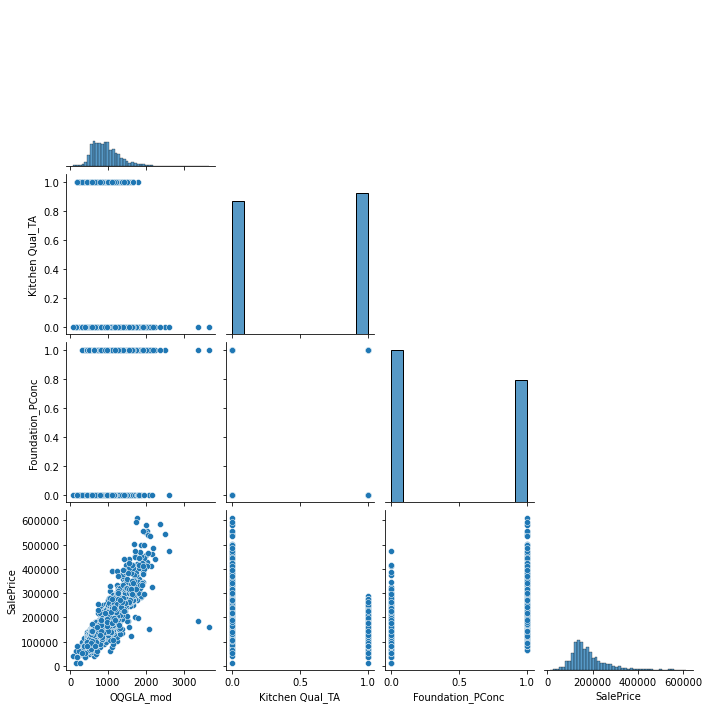

In [57]:
sns.pairplot(df[features[:3]].join(df['SalePrice']), corner=True);

In [47]:
lr = LinearRegression()

In [48]:
ss = StandardScaler()
ss.fit(X_train)

StandardScaler()

In [49]:
X_train_sc = ss.transform(X_train)
X_test_sc = ss.transform(X_test)

In [50]:
cross_val_score(lr, X_train, y_train).mean()

0.7908758823690516

In [51]:
y_train_log = y_train.map(np.log)
y_test_log = y_test.map(np.log)

cross_val_score(lr, X_train, y_train_log).mean()

0.7725371222814494

In [52]:
lr.fit(X_train, y_train)

LinearRegression()

In [54]:
test_pred = lr.predict(X_test)

In [55]:
test_resid = y_test - test_pred

<AxesSubplot:>

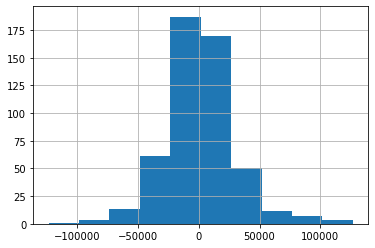

In [58]:
test_resid.hist()

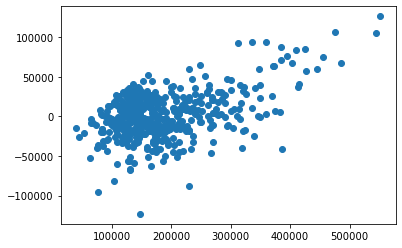

In [56]:
plt.scatter(y_test, test_resid)

In [59]:
df_kaggle = pd.read_csv('../datasets/filtered_test_dataset.csv')
df_kaggle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878 entries, 0 to 877
Columns: 148 entries, Id to Yr Sold_2010
dtypes: float64(2), int64(146)
memory usage: 1015.3 KB


In [60]:
df_kaggle['OQGLA_mod'] = (df_kaggle['Overall Qual'] * df_kaggle['Gr Liv Area']) ** .75

In [61]:
X_kaggle = df_kaggle[features].copy()
X_kaggle.isnull().sum().sort_values(ascending=False)

Mas Vnr Area            1
OQGLA_mod               0
Bsmt Exposure_Gd        0
Mas Vnr Type_Stone      0
Exterior 1st_VinylSd    0
Heating QC_TA           0
Sale Type_New           0
Foundation_CBlock       0
Garage Type_Attchd      0
MS SubClass_60          0
Garage Type_Detchd      0
Fireplace Qu_Gd         0
Kitchen Qual_TA         0
Mas Vnr Type_None       0
Garage Finish_Unf       0
Neighborhood_NridgHt    0
Exter Qual_Gd           0
Bsmt Qual_TA            0
BsmtFin Type 1_GLQ      0
Foundation_PConc        0
Kitchen Qual_Gd         0
dtype: int64

In [62]:
X_kaggle.shape

(878, 21)

In [63]:
imp_most = SimpleImputer(strategy='most_frequent')
imp_most.fit(X_train)

SimpleImputer(strategy='most_frequent')

In [64]:
imputed_values = imp_most.transform(X_kaggle)

In [65]:
imputed_X_kaggle = pd.DataFrame(imputed_values, columns=X_kaggle.columns)

In [66]:
pred_kaggle = lr.predict(imputed_X_kaggle)

In [67]:
pred = lr.predict(X_test)

In [68]:
lr.score(X_train, y_train)

0.8053897290443286

In [69]:
lr.score(X_test, y_test)

0.8702166730565659

In [70]:
cross_val_score(lr, X_train, y_train).mean()

0.7908758823690516

In [71]:
lr_log = LinearRegression()
lr_log.fit(X_train, y_train_log)

LinearRegression()

In [72]:
lr_log.score(X_train, y_train_log)

0.784629912118051

In [73]:
lr_log.score(X_test, y_test_log)

0.8470881339581648

In [74]:
cross_val_score(lr_log, X_train, y_train_log).mean()

0.7725371222814494

In [75]:
df_kaggle['SalePrice'] = pred_kaggle
df_kaggle['SalePrice'].head()

0    185825.774670
1    168372.883585
2    234654.977287
3    100363.968109
4    179666.583981
Name: SalePrice, dtype: float64

In [548]:
# pred_kaggle_2 = np.exp(pred_log_kaggle)

In [549]:
df_kaggle['SalePrice'] = pred_kaggle_2
# df_kaggle['SalePrice'].head()

0    165835.246007
1    185582.526486
2    186214.208547
3    119764.248510
4    163855.519078
Name: SalePrice, dtype: float64

In [76]:
submission = df_kaggle[['Id', 'SalePrice']]
submission.set_index('Id', inplace=True)
submission

,SalePrice
Id,
2658,185825.774670
2718,168372.883585
2414,234654.977287
1989,100363.968109
625,179666.583981
...,...
1662,170380.021144
1234,215565.597717
1373,131456.193353


In [77]:
submission.to_csv('../outputs/mlr_10_submission.csv')